In [24]:
import matplotlib.pyplot as plt

# Analiza zadnjih 100 oglasov na portalu avto.net (dne 26. 10. 2023)
V tem jupyter zvezku bomo naredili analizo avtomobilskih oglasov podstrani [zadnjih 100 oglasov](https://www.avto.net/Ads/results_100.asp?oglasrubrika=1&prodajalec=2) iz dne 26. 10. 2023.

## 1. Analiza z razpredelnicami
V prvem razdelku sem naredil analizo z razpredelnicami.

### 1.1 Splošna razpredelnica

In [7]:
import pandas as pd

zadnjih_100 = pd.read_csv('zadnjih_100.csv')
zadnjih_100.index += 1
pd.set_option('display.max_rows', 14)

In [2]:
zadnjih_100

,Ime,1.registracija,Prevoženih km,Gorivo,Menjalnik,Motor v KM,Cena v €
1,Volkswagen Passat CC 1.8 TSI avt.,2011,270000.0,bencinski motor,avtomatski menjalnik,160,7990
2,Kia Ceed,2008,200000.0,bencinski motor,ročni menjalnik,109,2600
3,Opel Insignia 2.0 CDTI EDITION VELIKA NAVI-PDC...,2015,241031.0,diesel motor,ročni menjalnik,163,7980
4,Renault Clio Rip Curl2 1.2 16v 3V,2008,263000.0,bencinski motor,ročni menjalnik,75,1300
5,Opel Grandland X 1.5 DIESEL 130 Elite - BOGATO...,2020,140000.0,diesel motor,ročni menjalnik,131,17490
...,...,...,...,...,...,...,...
94,Volkswagen Touran 1.9 TDI avt. Highline 77 105,2007,223000.0,diesel motor,ročni menjalnik,105,2590
95,Volkswagen Passat Variant 1.9 TDI 74 kW Highline,2003,NaN,diesel motor,ročni menjalnik,101,1390
96,Dodge Journey SXT 2.0 CRD 6M T],2009,335000.0,diesel motor,avtomatski menjalnik,140,1790
97,Peugeot 308 1.2°PureTech°STYLE°1LAST°SLO°NA OB...,2015,109800.0,bencinski motor,ročni menjalnik,131,8999


### 1.2 Razpredelnica, razvrščena po letu 1. registracije

In [3]:
zadnjih_100_razvrscenih_po_registraciji = zadnjih_100.sort_values('1.registracija')
zadnjih_100_razvrscenih_po_registraciji

,Ime,1.registracija,Prevoženih km,Gorivo,Menjalnik,Motor v KM,Cena v €
14,Proton serija 400: persona 416 GLXi,1996,216000.0,bencinski motor,ročni menjalnik,113,550
40,Audi A4 Avant 1.8i KLIMATRONIK 92kw LES PRIKLOP,1998,233000.0,bencinski motor,ročni menjalnik,125,250
42,Renault Twingo 1.2,1999,168000.0,bencinski motor,ročni menjalnik,58,720
68,Mercedes-Benz C-Razred W205,2000,165000.0,bencinski motor,ročni menjalnik,156,17500
95,Volkswagen Passat Variant 1.9 TDI 74 kW Highline,2003,NaN,diesel motor,ročni menjalnik,101,1390
...,...,...,...,...,...,...,...
33,Volkswagen Tiguan 2.0 TDi DSG7 Elegance - SLO ...,2021,29170.0,diesel motor,avtomatski menjalnik,150,29999
91,Škoda Octavia 2.0 TDI Style DSG 110 kW,2021,56000.0,diesel motor,avtomatski menjalnik,150,25900
98,Renault Zoe BOSE - LASTNIŠKA BATERIJA 52kw,2021,45000.0,elektro pogon,avtomatski menjalnik,134,19990
88,Volkswagen Passat Variant 2.0 TDI BMT SCR Busi...,2022,42000.0,diesel motor,avtomatski menjalnik,150,34900


### 1.3 Razpredelnica, razvrščena po ceni avtomobila

In [85]:
zadnjih_100_razvrscenih_po_ceni = zadnjih_100.sort_values('Cena v €', ascending=False)
zadnjih_100_razvrscenih_po_ceni

,Ime,1.registracija,Prevoženih km,Gorivo,Menjalnik,Motor v KM,Cena v €
55,Volkswagen Multivan BENCIN 2.0 TSI BULLI EDITION,2023,13700.0,bencinski motor,avtomatski menjalnik,204,55000
67,Audi SQ7 4.0TDI|quattro|7SEDEZEV|MATRIX|KAMERA...,2017,153000.0,diesel motor,avtomatski menjalnik,435,50990
34,BMW serija 3 Touring: 320d M Sport,2020,93699.0,diesel motor,avtomatski menjalnik,190,35999
17,Mercedes-Benz E-Razred E 200,2019,70000.0,bencinski motor,avtomatski menjalnik,184,35000
88,Volkswagen Passat Variant 2.0 TDI BMT SCR Busi...,2022,42000.0,diesel motor,avtomatski menjalnik,150,34900
...,...,...,...,...,...,...,...
42,Renault Twingo 1.2,1999,168000.0,bencinski motor,ročni menjalnik,58,720
80,Ford Focus 1.6 Zetec SE 100 KM,2005,210000.0,bencinski motor,ročni menjalnik,101,650
21,Seat Ibiza Fresc STELLA 1.4 16V 75,2004,210000.0,bencinski motor,ročni menjalnik,75,580
14,Proton serija 400: persona 416 GLXi,1996,216000.0,bencinski motor,ročni menjalnik,113,550


### 1.4 Razpredelnica, razvrščena po številu prevoženih kilometrov

In [10]:
zadnjih_100_razvrscenih_po_km = zadnjih_100.sort_values('Prevoženih km', ascending=False)
zadnjih_100_razvrscenih_po_km

,Ime,1.registracija,Prevoženih km,Gorivo,Menjalnik,Motor v KM,Cena v €
62,Mercedes-Benz CLK-Razred CLK 270 CDI AVANTGARDE,2004,409000.0,diesel motor,avtomatski menjalnik,170,3990
53,Volkswagen Passat Variant 2.0 TDI BlueM.Tech. ...,2011,355000.0,diesel motor,avtomatski menjalnik,140,9500
50,Opel Zafira 2.0 CDTI 121KW COSMO AUTO- 7 SEDEŽEV,2014,340000.0,diesel motor,avtomatski menjalnik,165,6500
96,Dodge Journey SXT 2.0 CRD 6M T],2009,335000.0,diesel motor,avtomatski menjalnik,140,1790
10,BMW serija X5: xDrive35d-BI-XENON-NAVI-PDC-SER...,2010,329000.0,diesel motor,avtomatski menjalnik,286,9900
...,...,...,...,...,...,...,...
33,Volkswagen Tiguan 2.0 TDi DSG7 Elegance - SLO ...,2021,29170.0,diesel motor,avtomatski menjalnik,150,29999
55,Volkswagen Multivan BENCIN 2.0 TSI BULLI EDITION,2023,13700.0,bencinski motor,avtomatski menjalnik,204,55000
19,Renault Clio °°Life 1.2 16v°°1LAST°°SLO°°94000...,2017,9300.0,bencinski motor,ročni menjalnik,75,8699
76,Jeep Compass 2.2 CRD 16v Limited 4x4,2012,NaN,diesel motor,ročni menjalnik,163,6990


### 1.5 Razpredelnica, razvrščena po moči motorja v KM

In [12]:
zadnjih_100_razvrscenih_po_KM = zadnjih_100.sort_values('Motor v KM', ascending=False)
zadnjih_100_razvrscenih_po_KM

,Ime,1.registracija,Prevoženih km,Gorivo,Menjalnik,Motor v KM,Cena v €
67,Audi SQ7 4.0TDI|quattro|7SEDEZEV|MATRIX|KAMERA...,2017,153000.0,diesel motor,avtomatski menjalnik,435,50990
10,BMW serija X5: xDrive35d-BI-XENON-NAVI-PDC-SER...,2010,329000.0,diesel motor,avtomatski menjalnik,286,9900
38,Audi A7 3.0 TDI-S LINE-ZRAČNO-MATRIX-STR.OKNO-...,2015,179582.0,diesel motor,avtomatski menjalnik,272,27940
20,Volkswagen Passat 3.2 FSI 4M R 32 4 MOTION DSG,2010,217900.0,bencinski motor,avtomatski menjalnik,250,4500
85,Volkswagen Golf 2.0 GTI Performance DSG,2017,139000.0,bencinski motor,avtomatski menjalnik,245,22800
...,...,...,...,...,...,...,...
84,Fiat 500 1.2 S,2017,88000.0,bencinski motor,ročni menjalnik,69,12900
39,Citroen C3 Attraction HDi 70 BVM,2014,159000.0,diesel motor,ročni menjalnik,68,4990
48,Kia Picanto 1.0 LX SPORT ABS AC SLOVENSKA. 2.L...,2005,158000.0,bencinski motor,ročni menjalnik,63,1290
86,Škoda Fabia 1.2 Happy-KOT NOVA-GARAŽIRANA,2009,233000.0,bencinski motor,ročni menjalnik,60,2650


## 2. Analiza z grafi
V tem razdelku sem naredil analizo podatkov z grafi in preučeval korelacije med posameznimi vrednostmi.

### 2.1 Število avtov z avtomatskim in ročnim menjalnikom
Tu sem preučil koliko avtov, ki so objavljeni na [podstrani](https://www.avto.net/Ads/results_100.asp?oglasrubrika=1&prodajalec=2), ima ročni menjalnik in koliko avtomatski. Vidimo lahko, da se prodaja več avtov z ročnim menjalnikom, kot z avtomatskim.

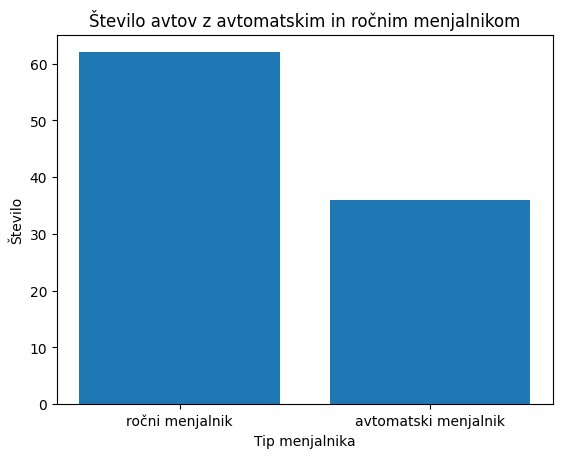

In [76]:
df = pd.read_csv('zadnjih_100.csv')
stevilo_pojavitev = df['Menjalnik'].value_counts()
plt.title('Število avtov z avtomatskim in ročnim menjalnikom')
plt.xlabel('Tip menjalnika')
plt.ylabel('Število')
plt.bar(stevilo_pojavitev.index, stevilo_pojavitev.values)
plt.show()

### 2.2 Število avtov pri različnem vrstu goriva
Tu sem preučil, koliko avtov ima dizelski in koliko bencinski motor. Vidimo, da je približno 3/5 dizelskih, 2/5 pa bencinskih avtomobilov. En je bil tudi na elektro pogon.

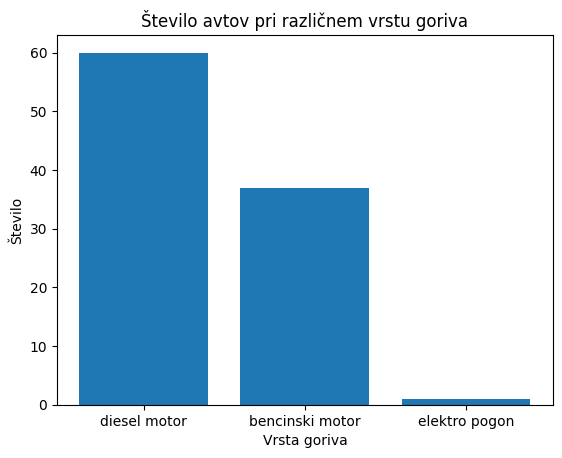

In [77]:
df = pd.read_csv('zadnjih_100.csv')
stevilo_pojavitev = df['Gorivo'].value_counts()
plt.title('Število avtov pri različnem vrstu goriva')
plt.xlabel('Vrsta goriva')
plt.ylabel('Število')
plt.bar(stevilo_pojavitev.index, stevilo_pojavitev.values)
plt.show()


### 2.3 Razmerje med prevoženimi km in ceno
Tu sem preučeval razmerje med prevoženimi km in ceno. Vidimo lahko grobo korelacijo, da več kot ima avto prevoženih kilometrov, manj je vreden. Opazimo tudi odstopanja.

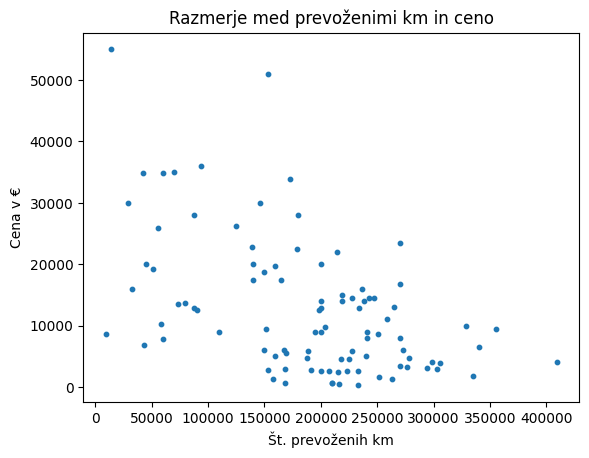

In [78]:
df = pd.read_csv('zadnjih_100.csv')
x = [prevozeni_km for prevozeni_km in df['Prevoženih km']]
y = [cena for cena in df['Cena v €']]
plt.scatter(x, y, s=10)
plt.xlabel('Št. prevoženih km')
plt.ylabel('Cena v €')
plt.title('Razmerje med prevoženimi km in ceno')
plt.show()

### 2.4 Razmerje med letnikom 1. registracije in ceno
Tu sem preučeval razmerje med letnikom 1. registracije in ceno. Vidimo lahko še boljšo korelacijo kot zgoraj; starejši kot je avto, manj je vreden.

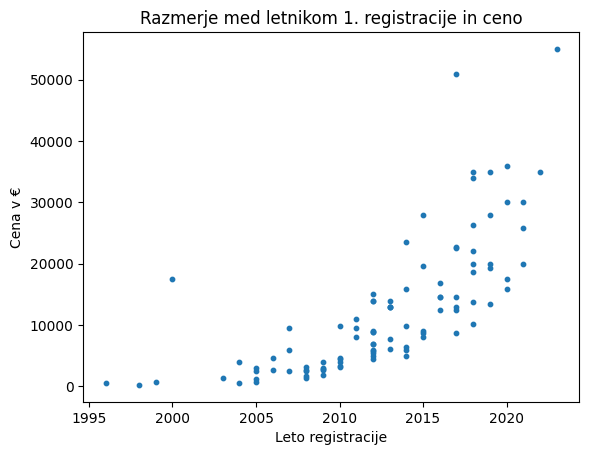

In [79]:
df = pd.read_csv('zadnjih_100.csv')
x = [leto_registracije for leto_registracije in df['1.registracija']]
y = [cena for cena in df['Cena v €']]
plt.scatter(x, y, s=10)
plt.xlabel('Leto registracije')
plt.ylabel('Cena v €')
plt.title('Razmerje med letnikom 1. registracije in ceno')
plt.show()

### 2.5 Cena avtov z ročnim vs. avtomatskim menjalnikom
Tu sem preučeval cene avtov z ročnim in avtomatskim menjalnikom. Vidimo lahko, da so avti z avtomatskim menjalnikom praviloma dražji od tistih z ročnim.

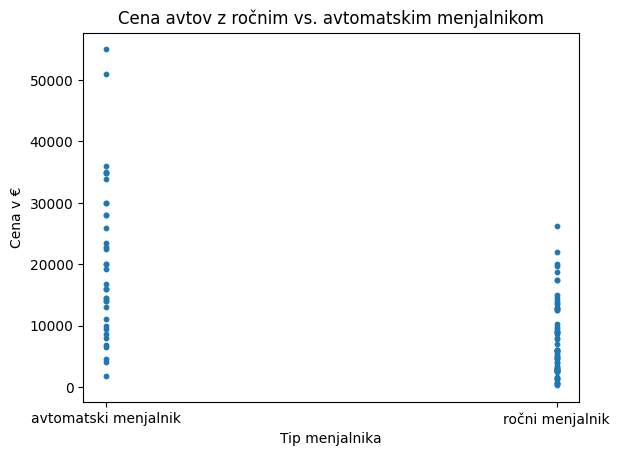

In [80]:
df = pd.read_csv('zadnjih_100.csv')
x = [tip_menjalnika for tip_menjalnika in df['Menjalnik']]
y = [cena for cena in df['Cena v €']]
plt.scatter(x, y, s=10)
plt.xlabel('Tip menjalnika')
plt.ylabel('Cena v €')
plt.title('Cena avtov z ročnim vs. avtomatskim menjalnikom')
plt.show()


### 2.6 Razmerje med močjo motorja in gorivom
Tu sem preučeval razmerje med močjo motorja in gorivom. Tu ni neke močne korelacije, vidimo rahlo nagnjenost, da so dizelski avti močnejši, vendar je zaradi majhne količine obdelanih podatkov to težko reči.

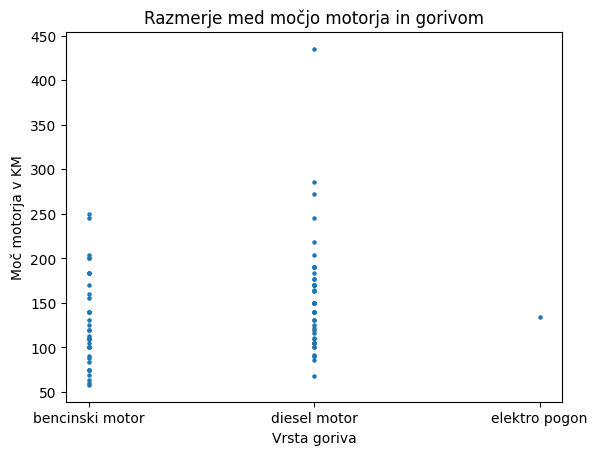

In [81]:
df = pd.read_csv('zadnjih_100.csv')
x = [vrsta_goriva for vrsta_goriva in df['Gorivo']]
y = [moc_motorja for moc_motorja in df['Motor v KM']]
plt.scatter(x, y, s=5)
plt.xlabel('Vrsta goriva')
plt.ylabel('Moč motorja v KM')
plt.title('Razmerje med močjo motorja in gorivom')
plt.show()

### 2.7 Razmerje med močjo motorja in tipom menjalnika
Tu sem preučeval razmerje med močjo motorja in tipom menjalnika. Na grafu se lepo vidi, da so avti z avtomatskim menjalnikom povprečno močnejši, od tistih z ročnim.

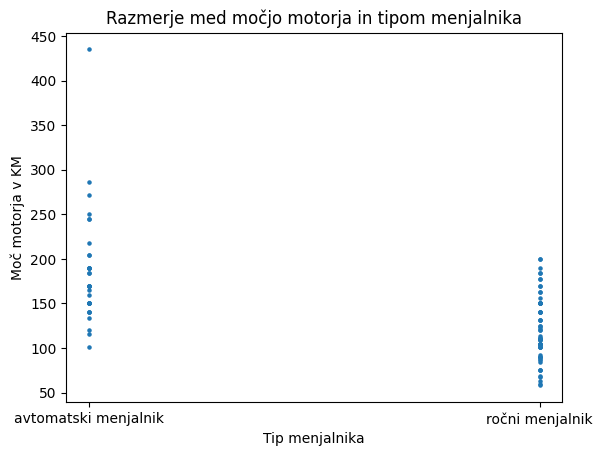

In [82]:
#Moč motorja v KM in menjalnik
df = pd.read_csv('zadnjih_100.csv')
x = [tip_menjalnika for tip_menjalnika in df['Menjalnik']]
y = [moc_motorja for moc_motorja in df['Motor v KM']]
plt.scatter(x, y, s=5)
plt.xlabel('Tip menjalnika')
plt.ylabel('Moč motorja v KM')
plt.title('Razmerje med močjo motorja in tipom menjalnika')
plt.show()

### 2.8 Razmerje med št. prevoženih kilometrov in letom 1. registracije
Tu sem preučeval razmerje med št. prevoženih kilometrov in letom 1. registracije. Mislil bi si, da bo bolj vidno, da imajo starejši avti več prevoženih kilometrov, vendar ni močne korelacije. K temu bi lahko prispevala tudi majhna količina obdelanih podatkov.

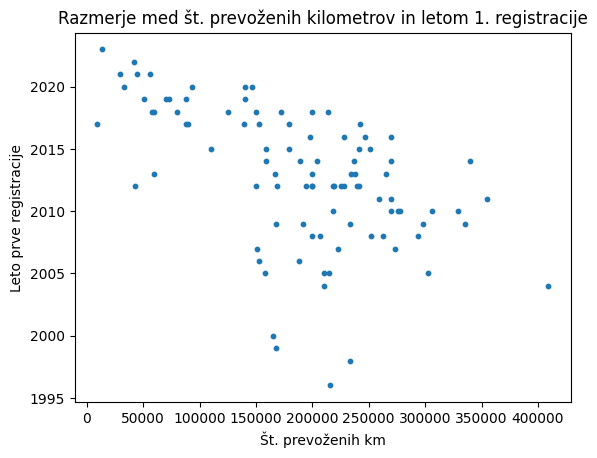

In [83]:
df = pd.read_csv('zadnjih_100.csv')
x = [prevozeni_kilometri for prevozeni_kilometri in df['Prevoženih km']]
y = [leto_registracije for leto_registracije in df['1.registracija']]
plt.scatter(x, y, s=10)
plt.xlabel('Št. prevoženih km')
plt.ylabel('Leto prve registracije')
plt.title('Razmerje med št. prevoženih kilometrov in letom 1. registracije')
plt.show()

### 2.9 Razmerje med ceno in močjo motorja
Tu sem preučeval razmerje med ceno in močjo motorja. Na grafu se lepo vidi povezava, da so močnejši avti tudi dražji.

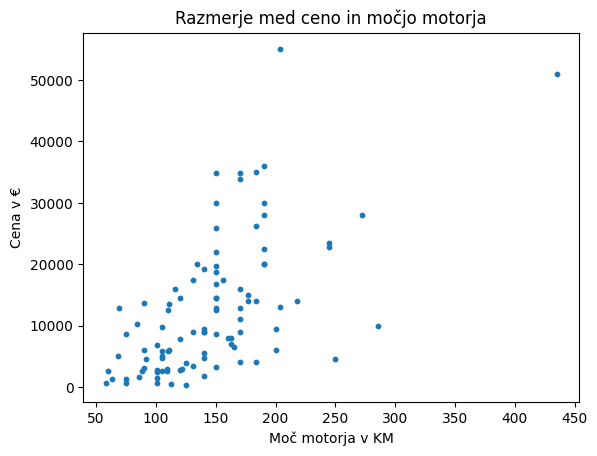

In [84]:
#razmerje med močjo motorja in ceno
df = pd.read_csv('zadnjih_100.csv')
x = [moc_motorja for moc_motorja in df['Motor v KM']]
y = [cena for cena in df['Cena v €']]
plt.scatter(x, y, s=10)
plt.xlabel('Moč motorja v KM')
plt.ylabel('Cena v €')
plt.title('Razmerje med ceno in močjo motorja')
plt.show()

### 2.10 Število registriranih avtov v posameznem letu
Tu sem preučeval število registriranih avtov v posameznem letu. Vidimo lahko, da se na portalu [avto.net](https://avto.net/) prodaja največ avtov, ki so od 10 do 15 let stari.

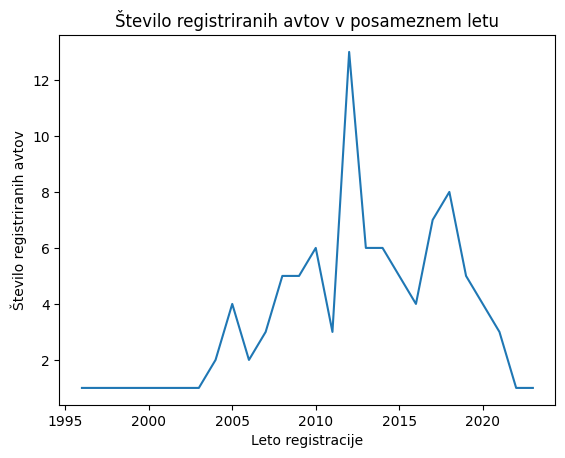

In [75]:
#Število registriranih avtov v posameznem letu skozi čas
import funkcije

df = pd.read_csv('zadnjih_100.csv')
x_sez = [leto for leto in df['1.registracija']]
x_sez.sort() #dobimo vsa leta in jih razvrstimo .. [1996, 1998, 1999, 2000, 2003, 2004, 2004...]
x_sez_po_eno = funkcije.vzemi_po_eno(x_sez)
y_sez = []

for leto in x_sez_po_eno:
    a = x_sez.count(leto)
    y_sez.append(a)
plt.plot(x_sez_po_eno, y_sez)
plt.xlabel('Leto registracije')
plt.ylabel('Število registriranih avtov')
plt.title('Število registriranih avtov v posameznem letu')
plt.show()

### 2.11 Število ročnih in avtomatskih menjalnikov po letih
Tu sem preučeval število avtov z ročnim (z modro barvo) in avtomatskim menjalnikom (z oranžno barvo) po letih. Hotel sem pokazati, da je v sedanjih časih več avtov z avtomatskim menjalnikom, kot v časih, kar se nekako vidi na grafu po letu 2005. Število avtomobilov z ročnim menjalnikom pa je od vrha v prvi polovici prejšnjega desetletja upadlo (vsaj na portalu [avto.net](https://avto.net/)). Če bi obdelal več podatkov, bi se lahko to lepše videlo.

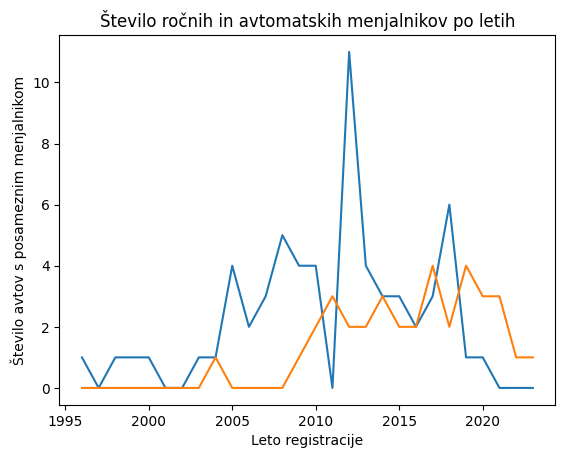

In [118]:
import funkcije

df = pd.read_csv('zadnjih_100.csv')
x_sez = [leto for leto in df['1.registracija']]
x_sez.sort()#seznam let po vrsti
x_sez_po_eno = range(1996, 2024)


#izločimo menjalnike zapisane po vrsti iz ustrezne tabele (kjer so vrednosti razvrščene po letu 1.registracije)
y_sez = zadnjih_100_razvrscenih_po_registraciji['Menjalnik'].tolist()

#Ustvarimo slovar za shranjevanje števila 'ročni menjalnik' za vsako leto
stevilo_rocnih_menjalnikov = {}

#Za vsako leto preštejemo, kolikokrat se pojavi 'ročni menjalnik'
for leto in range(min(x_sez), max(x_sez)+1):
    stevilo_rocnih_menjalnikov[leto] = 0

for leto, menjalnik_tip in zip(x_sez, y_sez):
    if menjalnik_tip == 'ročni menjalnik':
        stevilo_rocnih_menjalnikov[leto] += 1

#V seznam shranimo število 'ročni menjalnik' za vsako leto
y_sez_koncen = []
for leto, stevilo in stevilo_rocnih_menjalnikov.items():
    y_sez_koncen.append(stevilo)


#Sedaj pa še število avtomatskih menjalnikov

#Ustvarimo slovar za shranjevanje števila 'avtomatski menjalnik' za vsako leto
stevilo_avtomatskih_menjalnikov = {}

#Za vsako leto preštejemo, kolikokrat se pojavi 'avtomatski menjalnik'
for leto in range(min(x_sez), max(x_sez)+1):
    stevilo_avtomatskih_menjalnikov[leto] = 0

for leto, menjalnik_tip in zip(x_sez, y_sez):
    if menjalnik_tip == 'avtomatski menjalnik':
        stevilo_avtomatskih_menjalnikov[leto] += 1

#V seznam shranimo število 'avtomatski menjalnik' za vsako leto
y_sez_koncen_2 = []
for leto, stevilo in stevilo_avtomatskih_menjalnikov.items():
    y_sez_koncen_2.append(stevilo)

plt.plot(x_sez_po_eno, y_sez_koncen)
plt.plot(x_sez_po_eno, y_sez_koncen_2)
plt.xlabel('Leto registracije')
plt.ylabel('Število avtov s posameznim menjalnikom')
plt.title('Število ročnih in avtomatskih menjalnikov po letih')
plt.show()